In [3]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 32  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.1

'''batch_size = 64  # how many independent sequences will we process in parallel?
block_size = 256  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2'''
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input_sp0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):  # the heads handle the attention - the communication between the nodes (tokens)
    """ one head of self-attention """

    def __init__(self, head_size):  # takes headsize
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)  # k,q,v like above
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))  # tril is not a parameter of the model, a buffer in pytorch lingo
        # (so it does not get picked up by autograd)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x)  # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])  # pytorch makes this easy for us, passing just a list of heads
        self.proj = nn.Linear(n_embd, n_embd)  # project back into the original pathway
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # just concatinate the results, concat over channel dimension (dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):  # this handles the per-token (node) computation
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # the inner ff layer has 4 times the embedding dimension (to grow the computation on the residual pathway)
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # this is the projection layer going back into the original pathway (for the skip-connection) and going down from 4x
            nn.Dropout(dropout),  # added right before the residual pathway comes back (dropout trains subnetworks by randomly shutting off neurons)
        )

    def forward(self, x):
        return self.net(x)  # this is at a per token level: they think on all the attention data they got individually

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head  # watch out that it works out channelwise (e.g. 32 embedding, 4 heads, 8 headsize)
        self.sa = MultiHeadAttention(n_head, head_size)  # the heads running in parallel - the communication
        self.ffwd = FeedFoward(n_embd)  # simple feedforward: at token level, all tokens do this independently: gathered all info from attention, think on it
        # the ff does the computations
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):  # with skip connection, forking off direct gradient pass-through and block adjustments
        x = x + self.sa(self.ln1(x))  # the x + is the skip connection: it lets the gradient pass through (particularly initially), then the blocks adjust
        x = x + self.ffwd(self.ln2(x))  # note that the layer norms are applied before it goes into self-attention or ff, per token
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # now the network starts to get really deep: suffers from computation problems, two ways to address this: (see Add & Norm in the figure)
        # 1. skip (residual) connections, see https://github.com/KaimingHe/deep-residual-networks (lets gradients pass through and lets blocks adjust them gradually)
        # 2. layer norms = Norm: similar to batch normalization: ensure each neuron has unit Gaussian distribution accross batch dimension
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm (now it is more common to norm before the computations unlike in the trafo paper - called prenorm)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens (idx also has the PE so we need to crop) (not doing this causes a CUDA error due to index out of bounds)
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.4116, val loss 4.4022
step 100: train loss 2.6699, val loss 2.6800
step 200: train loss 2.5187, val loss 2.5149
step 300: train loss 2.4356, val loss 2.4497
step 400: train loss 2.3679, val loss 2.3743
step 500: train loss 2.3207, val loss 2.3348
step 600: train loss 2.2704, val loss 2.2743
step 700: train loss 2.2348, val loss 2.2471
step 800: train loss 2.1952, val loss 2.2139
step 900: train loss 2.1577, val loss 2.1751
step 1000: train loss 2.1364, val loss 2.1478
step 1100: train loss 2.1043, val loss 2.1398
step 1200: train loss 2.0832, val loss 2.1082
step 1300: train loss 2.0714, val loss 2.0976
step 1400: train loss 2.0365, val loss 2.0662
step 1500: train loss 2.0116, val loss 2.0593
step 1600: train loss 1.9980, val loss 2.0625
step 1700: train loss 1.9898, val loss 2.0430
step 1800: train loss 1.9632, val loss 2.0352
step 1900: train loss 1.9523, val loss 2.0103
step 2000: train loss 1.9383, val loss 2.0184
step 2100: train loss 1.

In [4]:
# increase input text file length

with open('input_sp0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text += ' ' + text

# Writing to file
with open("input_sp1.txt", "w") as f:
    # Writing data to a file
    f.write(text)


In [ ]:
# with double the file length there is barely any overfitting

In [5]:
import torch
import torch.nn as nn
from torch.nn import functional as F

# hyperparameters
batch_size = 16  # how many independent sequences will we process in parallel?
block_size = 32  # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 100
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 64
n_head = 4
n_layer = 4
dropout = 0.0
# ------------

torch.manual_seed(1337)

# wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt
with open('input_sp1.txt', 'r', encoding='utf-8') as f:
    text = f.read()

# here are all the unique characters that occur in this text
chars = sorted(list(set(text)))
vocab_size = len(chars)
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s] # encoder: take a string, output a list of integers
decode = lambda l: ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# Train and test splits
data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data)) # first 90% will be train, rest val
train_data = data[:n]
val_data = data[n:]

# data loading
def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):  # the heads handle the attention - the communication between the nodes (tokens)
    """ one head of self-attention """

    def __init__(self, head_size):  # takes headsize
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)  # k,q,v like above
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))  # tril is not a parameter of the model, a buffer in pytorch lingo
        # (so it does not get picked up by autograd)

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,C)
        q = self.query(x)  # (B,T,C)
        # compute attention scores ("affinities")
        wei = q @ k.transpose(-2,-1) * C**-0.5  # (B, T, C) @ (B, C, T) -> (B, T, T)
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1) # (B, T, T)
        wei = self.dropout(wei)
        # perform the weighted aggregation of the values
        v = self.value(x)  # (B,T,C)
        out = wei @ v  # (B, T, T) @ (B, T, C) -> (B, T, C)
        return out

class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])  # pytorch makes this easy for us, passing just a list of heads
        self.proj = nn.Linear(n_embd, n_embd)  # project back into the original pathway
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # just concatinate the results, concat over channel dimension (dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedFoward(nn.Module):  # this handles the per-token (node) computation
    """ a simple linear layer followed by a non-linearity """

    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),  # the inner ff layer has 4 times the embedding dimension (to grow the computation on the residual pathway)
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),  # this is the projection layer going back into the original pathway (for the skip-connection) and going down from 4x
            nn.Dropout(dropout),  # added right before the residual pathway comes back (dropout trains subnetworks by randomly shutting off neurons)
        )

    def forward(self, x):
        return self.net(x)  # this is at a per token level: they think on all the attention data they got individually

class Block(nn.Module):
    """ Transformer block: communication followed by computation """

    def __init__(self, n_embd, n_head):
        # n_embd: embedding dimension, n_head: the number of heads we'd like
        super().__init__()
        head_size = n_embd // n_head  # watch out that it works out channelwise (e.g. 32 embedding, 4 heads, 8 headsize)
        self.sa = MultiHeadAttention(n_head, head_size)  # the heads running in parallel - the communication
        self.ffwd = FeedFoward(n_embd)  # simple feedforward: at token level, all tokens do this independently: gathered all info from attention, think on it
        # the ff does the computations
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):  # with skip connection, forking off direct gradient pass-through and block adjustments
        x = x + self.sa(self.ln1(x))  # the x + is the skip connection: it lets the gradient pass through (particularly initially), then the blocks adjust
        x = x + self.ffwd(self.ln2(x))  # note that the layer norms are applied before it goes into self-attention or ff, per token
        return x

# super simple bigram model
class BigramLanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # now the network starts to get really deep: suffers from computation problems, two ways to address this: (see Add & Norm in the figure)
        # 1. skip (residual) connections, see https://github.com/KaimingHe/deep-residual-networks (lets gradients pass through and lets blocks adjust them gradually)
        # 2. layer norms = Norm: similar to batch normalization: ensure each neuron has unit Gaussian distribution accross batch dimension
        self.ln_f = nn.LayerNorm(n_embd)  # final layer norm (now it is more common to norm before the computations unlike in the trafo paper - called prenorm)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        # idx and targets are both (B,T) tensor of integers
        tok_emb = self.token_embedding_table(idx)  # (B,T,C)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))  # (T,C)
        x = tok_emb + pos_emb  # (B,T,C)
        x = self.blocks(x)  # (B,T,C)
        x = self.ln_f(x)  # (B,T,C)
        logits = self.lm_head(x)  # (B,T,vocab_size)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens (idx also has the PE so we need to crop) (not doing this causes a CUDA error due to index out of bounds)
            idx_cond = idx[:, -block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

model = BigramLanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

# generate from the model
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))

0.209729 M parameters
step 0: train loss 4.4086, val loss 4.4042
step 100: train loss 2.6523, val loss 2.6555
step 200: train loss 2.4994, val loss 2.5055
step 300: train loss 2.4131, val loss 2.4304
step 400: train loss 2.3452, val loss 2.3614
step 500: train loss 2.3022, val loss 2.3056
step 600: train loss 2.2582, val loss 2.2726
step 700: train loss 2.1969, val loss 2.2117
step 800: train loss 2.1801, val loss 2.1993
step 900: train loss 2.1333, val loss 2.1499
step 1000: train loss 2.1000, val loss 2.1186
step 1100: train loss 2.0730, val loss 2.0943
step 1200: train loss 2.0477, val loss 2.0648
step 1300: train loss 2.0169, val loss 2.0488
step 1400: train loss 1.9951, val loss 2.0256
step 1500: train loss 1.9823, val loss 2.0090
step 1600: train loss 1.9570, val loss 1.9924
step 1700: train loss 1.9489, val loss 1.9794
step 1800: train loss 1.9309, val loss 1.9527
step 1900: train loss 1.9167, val loss 1.9405
step 2000: train loss 1.9054, val loss 1.9344
step 2100: train loss 1.

In [7]:
# byte-pair encoding
# https://ufal.mff.cuni.cz/~helcl/courses/npfl116/ipython/byte_pair_encoding.html

import re, collections

def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out



In [29]:
from IPython.display import display, Markdown, Latex

train_data = {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}  # word: frequency

bpe_codes = {}
bpe_codes_reverse = {}

num_merges = 15

for i in range(num_merges):
    display(Markdown("### Iteration {}".format(i + 1)))
    pairs = get_stats(train_data)
    best = max(pairs, key=pairs.get)
    train_data = merge_vocab(best, train_data)
    
    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best
    
    print("new merge: {}".format(best))
    print("train data: {}".format(train_data))

print(bpe_codes)

### Iteration 1

new merge: ('e', 's')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w es t </w>': 6, 'w i d es t </w>': 3}


### Iteration 2

new merge: ('es', 't')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est </w>': 6, 'w i d est </w>': 3}


### Iteration 3

new merge: ('est', '</w>')
train data: {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 4

new merge: ('l', 'o')
train data: {'lo w </w>': 5, 'lo w e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 5

new merge: ('lo', 'w')
train data: {'low </w>': 5, 'low e r </w>': 2, 'n e w est</w>': 6, 'w i d est</w>': 3}


### Iteration 6

new merge: ('n', 'e')
train data: {'low </w>': 5, 'low e r </w>': 2, 'ne w est</w>': 6, 'w i d est</w>': 3}


### Iteration 7

new merge: ('ne', 'w')
train data: {'low </w>': 5, 'low e r </w>': 2, 'new est</w>': 6, 'w i d est</w>': 3}


### Iteration 8

new merge: ('new', 'est</w>')
train data: {'low </w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 9

new merge: ('low', '</w>')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'w i d est</w>': 3}


### Iteration 10

new merge: ('w', 'i')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wi d est</w>': 3}


### Iteration 11

new merge: ('wi', 'd')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'wid est</w>': 3}


### Iteration 12

new merge: ('wid', 'est</w>')
train data: {'low</w>': 5, 'low e r </w>': 2, 'newest</w>': 6, 'widest</w>': 3}


### Iteration 13

new merge: ('low', 'e')
train data: {'low</w>': 5, 'lowe r </w>': 2, 'newest</w>': 6, 'widest</w>': 3}


### Iteration 14

new merge: ('lowe', 'r')
train data: {'low</w>': 5, 'lower </w>': 2, 'newest</w>': 6, 'widest</w>': 3}


### Iteration 15

new merge: ('lower', '</w>')
train data: {'low</w>': 5, 'lower</w>': 2, 'newest</w>': 6, 'widest</w>': 3}
{('e', 's'): 0, ('es', 't'): 1, ('est', '</w>'): 2, ('l', 'o'): 3, ('lo', 'w'): 4, ('n', 'e'): 5, ('ne', 'w'): 6, ('new', 'est</w>'): 7, ('low', '</w>'): 8, ('w', 'i'): 9, ('wi', 'd'): 10, ('wid', 'est</w>'): 11, ('low', 'e'): 12, ('lowe', 'r'): 13, ('lower', '</w>'): 14}


In [9]:
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs


def encode(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    display(Markdown("__word split into characters:__ <tt>{}</tt>".format(word)))

    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        display(Markdown("__Iteration {}:__".format(iteration)))
        
        print("bigrams in the word: {}".format(pairs))
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        print("candidate for merging: {}".format(bigram))
        if bigram not in bpe_codes:
            display(Markdown("__Candidate not in BPE merges, algorithm stops.__"))
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        print("word after merging: {}".format(word))
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # don't print end-of-word symbols
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)
   
    return word

In [10]:
encode("lowest")

__word split into characters:__ <tt>('l', 'o', 'w', 'e', 's', 't', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('s', 't'), ('o', 'w'), ('e', 's'), ('w', 'e'), ('t', '</w>'), ('l', 'o')}
candidate for merging: ('e', 's')
word after merging: ('l', 'o', 'w', 'es', 't', '</w>')


__Iteration 2:__

bigrams in the word: {('o', 'w'), ('w', 'es'), ('es', 't'), ('t', '</w>'), ('l', 'o')}
candidate for merging: ('es', 't')
word after merging: ('l', 'o', 'w', 'est', '</w>')


__Iteration 3:__

bigrams in the word: {('est', '</w>'), ('o', 'w'), ('l', 'o'), ('w', 'est')}
candidate for merging: ('est', '</w>')
word after merging: ('l', 'o', 'w', 'est</w>')


__Iteration 4:__

bigrams in the word: {('o', 'w'), ('l', 'o'), ('w', 'est</w>')}
candidate for merging: ('l', 'o')
word after merging: ('lo', 'w', 'est</w>')


__Iteration 5:__

bigrams in the word: {('w', 'est</w>'), ('lo', 'w')}
candidate for merging: ('lo', 'w')
word after merging: ('low', 'est</w>')


__Iteration 6:__

bigrams in the word: {('low', 'est</w>')}
candidate for merging: ('low', 'est</w>')


__Candidate not in BPE merges, algorithm stops.__

('low', 'est')

In [11]:
bpe_codes

{('e', 's'): 0,
 ('es', 't'): 1,
 ('est', '</w>'): 2,
 ('l', 'o'): 3,
 ('lo', 'w'): 4,
 ('n', 'e'): 5,
 ('ne', 'w'): 6,
 ('new', 'est</w>'): 7,
 ('low', '</w>'): 8,
 ('w', 'i'): 9,
 ('wi', 'd'): 10,
 ('wid', 'est</w>'): 11,
 ('low', 'e'): 12,
 ('lowe', 'r'): 13,
 ('lower', '</w>'): 14}

In [2]:
# BPE w/o output
def get_pairs(word):
    """Return set of symbol pairs in a word.
    Word is represented as a tuple of symbols (symbols being variable-length strings).
    """
    pairs = set()
    prev_char = word[0]
    for char in word[1:]:
        pairs.add((prev_char, char))
        prev_char = char
    return pairs
    

def encode_bp(orig):
    """Encode word based on list of BPE merge operations, which are applied consecutively"""

    word = tuple(orig) + ('</w>',)
    pairs = get_pairs(word)    

    if not pairs:
        return orig

    iteration = 0
    while True:
        iteration += 1
        bigram = min(pairs, key = lambda pair: bpe_codes.get(pair, float('inf')))
        if bigram not in bpe_codes:
            break
        first, second = bigram
        new_word = []
        i = 0
        while i < len(word):
            try:
                j = word.index(first, i)
                new_word.extend(word[i:j])
                i = j
            except:
                new_word.extend(word[i:])
                break

            if word[i] == first and i < len(word)-1 and word[i+1] == second:
                new_word.append(first+second)
                i += 2
            else:
                new_word.append(word[i])
                i += 1
        new_word = tuple(new_word)
        word = new_word
        if len(word) == 1:
            break
        else:
            pairs = get_pairs(word)

    # don't print end-of-word symbols
    if word[-1] == '</w>':
        word = word[:-1]
    elif word[-1].endswith('</w>'):
        word = word[:-1] + (word[-1].replace('</w>',''),)
   
    return word
    

In [36]:
encode_bp("lowest")

('l', 'o', 'w', 'es', 't')

In [55]:
# train BPE with our input text
import re, collections

def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

with open('inp_testbpe0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub(r'[^\w]', ' ', text)  # remove all symbols

text = text.replace('\n', ' ')
words = sorted(list(set(text.lower().split(' '))))
wordfreq = {w: text.count(w) for w in words}
#print(words)
print(wordfreq)

#print({(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))})

#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))}
#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(words)}
#train_data = {(v + '</w>'):idx for idx,v in enumerate(words)}
#train_data = {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
#train_data = wordfreq
train_data = {(' '.join([el for el in key]) + ' </w>'):val for key,val in wordfreq.items()}
print(train_data)
#print(get_stats(train_data))

bpe_codes = {}
bpe_codes_reverse = {}

#num_merges = length of word l, length of subword n: l! / (n!(l-n)!) --> sum for n=1 to l = 2**l - 1 + number of words
# average word length
avrgwordlen = sum([len(w) for w in words]) / len(words)
num_merges = 2**int(avrgwordlen+1) - 1 + len(words)
# simpler: number of words * 2 seems to work just as well
#num_merges = 2*len(words)
print(f"numer of words: {len(words)} avrg word length: {avrgwordlen} --> number of merges: {num_merges}")

for i in range(num_merges):
    #print("### Iteration {}".format(i + 1))
    pairs = get_stats(train_data)
    best = max(pairs, key = pairs.get)
    train_data = merge_vocab(best, train_data)
    
    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best
    
    #print("new merge: {}".format(best))
    #print("train data: {}".format(train_data))

print(bpe_codes)
print()

#for word in words:
encodedlen = 0
for word in text.split(' '):
    wordencoded = encode_bp(word.lower())
    print(f"word: {word} --> {wordencoded}")
    encodedlen += len(wordencoded)

print(encodedlen / len(text.split(' ')))

{'': 1137, 'a': 53, 'abundance': 1, 'account': 2, 'accounted': 1, 'accusations': 1, 'afflicts': 1, 'altitude': 1, 'an': 9, 'and': 1, 'are': 3, 'as': 3, 'authority': 1, 'barren': 1, 'be': 4, 'become': 1, 'bread': 1, 'but': 2, 'can': 2, 'cannot': 1, 'capitol': 0, 'citizen': 1, 'citizens': 1, 'city': 1, 'conscienced': 1, 'content': 1, 'country': 1, 'covetous': 1, 'dear': 1, 'did': 2, 'done': 1, 'end': 1, 'ere': 3, 'even': 3, 'famously': 1, 'faults': 1, 'first': 0, 'for': 4, 'gain': 1, 'gods': 1, 'good': 1, 'guess': 1, 'hath': 2, 'he': 26, 'help': 1, 'here': 1, 'him': 1, 'his': 6, 'humanely': 1, 'hunger': 1, 'i': 75, 'if': 1, 'in': 10, 'inventory': 1, 'is': 14, 'it': 18, 'know': 1, 'leanness': 1, 'let': 0, 'men': 1, 'might': 1, 'misery': 1, 'mother': 1, 'must': 2, 'nature': 1, 'need': 1, 'no': 6, 'not': 4, 'o': 64, 'object': 1, 'of': 4, 'on': 7, 'other': 2, 'our': 3, 'particularise': 1, 'partly': 1, 'patricians': 1, 'pikes': 1, 'please': 1, 'poor': 1, 'prating': 1, 'proud': 1, 'rakes': 1, 

In [40]:
encode('migrate')

__word split into characters:__ <tt>('m', 'i', 'g', 'r', 'a', 't', 'e', '</w>')</tt>

__Iteration 1:__

bigrams in the word: {('i', 'g'), ('t', 'e'), ('m', 'i'), ('e', '</w>'), ('a', 't'), ('g', 'r'), ('r', 'a')}
candidate for merging: ('e', '</w>')
word after merging: ('m', 'i', 'g', 'r', 'a', 't', 'e</w>')


__Iteration 2:__

bigrams in the word: {('i', 'g'), ('m', 'i'), ('a', 't'), ('g', 'r'), ('r', 'a'), ('t', 'e</w>')}
candidate for merging: ('m', 'i')
word after merging: ('mi', 'g', 'r', 'a', 't', 'e</w>')


__Iteration 3:__

bigrams in the word: {('mi', 'g'), ('a', 't'), ('g', 'r'), ('r', 'a'), ('t', 'e</w>')}
candidate for merging: ('mi', 'g')


__Candidate not in BPE merges, algorithm stops.__

('mi', 'g', 'r', 'a', 't', 'e')

In [41]:
# how to integrate BPE into the LM?



# next steps:
# - implement positional encoding via sin/cos
# - test iterative transformer (i.e. iterative self-attention)

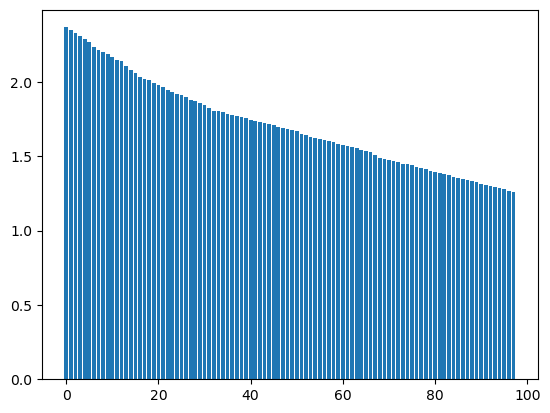

In [5]:
# test number of merges 
import re, collections
import matplotlib.pyplot as plt
import numpy as np

def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

with open('inp_testbpe0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub(r'[^\w]', ' ', text)  # remove all symbols

text = text.replace('\n', ' ')
words = sorted(list(set(text.lower().split(' '))))
wordfreq = {w: text.count(w) for w in words}


y = []

for num_merges in range(len(words)//2, 2*len(words), 2):
    
    train_data = {(' '.join([el for el in key]) + ' </w>'):val for key,val in wordfreq.items()}
    
    bpe_codes = {}
    bpe_codes_reverse = {}
    
    for i in range(num_merges):
        #print("### Iteration {}".format(i + 1))
        pairs = get_stats(train_data)
        best = max(pairs, key = pairs.get)
        train_data = merge_vocab(best, train_data)
        
        bpe_codes[best] = i
        bpe_codes_reverse[best[0] + best[1]] = best
        
        #print("new merge: {}".format(best))
        #print("train data: {}".format(train_data))
    
    #print(bpe_codes)
    #print()
    
    #for word in words:
    encodedlen = 0
    for word in text.split(' '):
        wordencoded = encode_bp(word.lower())
        #print(f"word: {word} --> {wordencoded}")
        encodedlen += len(wordencoded)
    
    #print(encodedlen / len(text.split(' ')))
    y.append(encodedlen / len(text.split(' ')))


x = np.arange(len(y))
plt.bar(x, height=y)
plt.show()

In [25]:
# train BPE and build symbolic embedding - test
import re, collections
import math


def get_stats(vocab):
    """Compute frequencies of adjacent pairs of symbols."""
    pairs = collections.defaultdict(int)
    for word, freq in vocab.items():
        symbols = word.split()
        for i in range(len(symbols)-1):
            pairs[symbols[i],symbols[i+1]] += freq
    return pairs

def merge_vocab(pair, v_in):
    v_out = {}
    bigram = re.escape(' '.join(pair))
    p = re.compile(r'(?<!\S)' + bigram + r'(?!\S)')
    for word in v_in:
        w_out = p.sub(''.join(pair), word)
        v_out[w_out] = v_in[word]
    return v_out

with open('inp_testbpe0.txt', 'r', encoding='utf-8') as f:
    text = f.read()

text = re.sub(r'[^\w]', ' ', text)  # remove all symbols

text = text.replace('\n', ' ')
words = sorted(list(set(text.lower().split(' '))))
wordfreq = {w: text.count(w) for w in words}
#print(words)
#print(wordfreq)

#print({(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))})

#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(text.split(' '))}
#train_data = {(' '.join([el for el in v.lower()]) + ' </w>'):idx for idx,v in enumerate(words)}
#train_data = {(v + '</w>'):idx for idx,v in enumerate(words)}
#train_data = {'l o w </w>': 5, 'l o w e r </w>': 2, 'n e w e s t </w>': 6, 'w i d e s t </w>': 3}
#train_data = wordfreq
train_data = {(' '.join([el for el in key]) + ' </w>'):val for key,val in wordfreq.items()}
#print(train_data)
#print(get_stats(train_data))

bpe_codes = {}
bpe_codes_reverse = {}

#num_merges = length of word l, length of subword n: l! / (n!(l-n)!) --> sum for n=1 to l = 2**l - 1 + number of words
# average word length
avrgwordlen = sum([len(w) for w in words]) / len(words)
num_merges = 2**int(avrgwordlen+1) - 1 + len(words)
# simpler: number of words * 2 seems to work just as well
#num_merges = 2*len(words)
print(f"numer of words: {len(words)} avrg word length: {avrgwordlen} --> number of merges: {num_merges}")
print()

for i in range(num_merges):
    #print("### Iteration {}".format(i + 1))
    pairs = get_stats(train_data)
    best = max(pairs, key = pairs.get)
    train_data = merge_vocab(best, train_data)
    
    bpe_codes[best] = i
    bpe_codes_reverse[best[0] + best[1]] = best
    
    #print("new merge: {}".format(best))
    #print("train data: {}".format(train_data))

#print(bpe_codes)
#print()

bpesymbols = set()
textencoded = []

for word in text.split(' '):
    wordencoded = encode_bp(word.lower())
    for s in wordencoded:
        textencoded.append(s)
    textencoded.append('</w>')
    #print(f"word: {word} --> {wordencoded}")
    for w in wordencoded:
        bpesymbols.add(w)

#bpesymbols.add('</w>')

bpetoi = { symb:i for i, symb in enumerate(bpesymbols) }
bpetoi['</w>'] = math.inf
print(bpetoi)

textbpesymb = [bpetoi[s] for s in textencoded]
print(textbpesymb)

numer of words: 130 avrg word length: 4.946153846153846 --> number of merges: 161

{'de': 0, 'ly': 1, 'for': 2, 'at': 3, 'th': 4, 'that': 5, 'authority': 6, 'abundance': 7, 'mi': 8, 'the': 9, 'say': 10, 'be': 11, 'you': 12, 'kes': 13, 'us': 14, 'a': 15, 'ty': 16, 'revenge': 17, 'ng': 18, 'account': 19, 'c': 20, 'become': 21, 'u': 22, 'ere': 23, 'ti': 24, 'b': 25, 'afflicts': 26, 'are': 27, 'whi': 28, 'k': 29, 'no': 30, 'oun': 31, 'au': 32, 'm': 33, 'our': 34, 'accusations': 35, 'go': 36, 'e': 37, 'o': 38, 'ea': 39, 'in': 40, 'ts': 41, 'as': 42, 'gh': 43, 'must': 44, 'p': 45, 'an': 46, 'n': 47, 'it': 48, 'did': 49, 'w': 50, 'hath': 51, 'h': 52, 'v': 53, 'pe': 54, 'ay': 55, 'citiz': 56, 't': 57, 'ce': 58, 'pl': 59, 'ati': 60, 'relieve': 61, 'other': 62, 'even': 63, 'barren': 64, 'l': 65, 's': 66, 'g': 67, 'su': 68, 'ance': 69, 'par': 70, 'this': 71, 'we': 72, 'rf': 73, 'eve': 74, 'of': 75, 'with': 76, 'ir': 77, 'ff': 78, 'wh': 79, 'se': 80, 'on': 81, 'or': 82, 'and': 83, 'ome': 84, 'he':

In [145]:
# positional encoding
import numpy as np
import math

positions = np.arange(4)
print(positions/4)  # unique values
positions = np.arange(8)
print(positions/4)  # unique but > 1

positions = np.arange(8)
print(np.remainder(positions, 4)/4)  # <1 but not unique

positions = np.arange(8)
positionvectors = np.ones(8) * np.array([np.remainder(positions, 4)/4, np.remainder(positions, 5)/5, np.remainder(positions, 7)/7])
print(positionvectors.T)
print()

print(np.linalg.norm(positionvectors.T[3] - positionvectors.T[2]))  # distances not equal
print(np.linalg.norm(positionvectors.T[4] - positionvectors.T[3]))

#print(positionvectors.T * np.deg2rad(360))  # angles
print()

print(f"sin: {np.sin(positionvectors.T * np.deg2rad(360))}")  # xy coordinates
print(f"cos: {np.cos(positionvectors.T * np.deg2rad(360))}")
print()

positionvectorssin = np.array([[np.sin(v[i]) for v in positionvectors.T * np.deg2rad(360)] for i in range(3)])
positionvectorscos = np.array([[np.cos(v[i]) for v in positionvectors.T * np.deg2rad(360)] for i in range(3)])

row_a, col_a = np.shape(positionvectorssin)
positionvectorsxy = np.ravel([positionvectorssin, positionvectorscos], order="F")
#positionvectorsxy = np.reshape(positionvectorsxy, (2*row_a, col_a))
positionvectorsxy = np.array([positionvectorsxy.tolist()[i:i+2*row_a] for i in range(0, 2*row_a*col_a, 2*row_a)])
print(positionvectorsxy.T)
print()

print(np.linalg.norm(positionvectorsxy.T[0:, 3] - positionvectorsxy.T[0:, 2]))  # distances are now equal
print(np.linalg.norm(positionvectorsxy.T[0:, 4] - positionvectorsxy.T[0:, 3]))


[0.   0.25 0.5  0.75]
[0.   0.25 0.5  0.75 1.   1.25 1.5  1.75]
[0.   0.25 0.5  0.75 0.   0.25 0.5  0.75]
[[0.         0.         0.        ]
 [0.25       0.2        0.14285714]
 [0.5        0.4        0.28571429]
 [0.75       0.6        0.42857143]
 [0.         0.8        0.57142857]
 [0.25       0.         0.71428571]
 [0.5        0.2        0.85714286]
 [0.75       0.4        0.        ]]

0.3505826054802293
0.7892453124759793

sin: [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.00000000e+00  9.51056516e-01  7.81831482e-01]
 [ 1.22464680e-16  5.87785252e-01  9.74927912e-01]
 [-1.00000000e+00 -5.87785252e-01  4.33883739e-01]
 [ 0.00000000e+00 -9.51056516e-01 -4.33883739e-01]
 [ 1.00000000e+00  0.00000000e+00 -9.74927912e-01]
 [ 1.22464680e-16  9.51056516e-01 -7.81831482e-01]
 [-1.00000000e+00  5.87785252e-01  0.00000000e+00]]
cos: [[ 1.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 6.12323400e-17  3.09016994e-01  6.23489802e-01]
 [-1.00000000e+00 -8.09016994e-01 -2.2252093

In [146]:
# https://helsinki-nlp.github.io/shroom/
